In [2]:
# block1_fmnist_data.py

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.Resize((28, 28))    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize grayscale to [-1, 1]
])
fmnist_train_full = datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform
)
fmnist_test = datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform
)

# Split training set into train/val
train_size = int(0.9 * len(fmnist_train_full))  # 54,000
val_size = len(fmnist_train_full) - train_size  # 6,000
train_data, val_data = random_split(fmnist_train_full, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(fmnist_test, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


In [3]:
# block2_resnet18_fmnist.py

import torch.nn as nn
import torchvision.models as models

def get_resnet18_for_fmnist(num_classes=10):
    model = models.resnet18(pretrained=False)

    # Adapt first conv layer to 1 input channel (grayscale)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)

    # Remove aggressive downsampling
    model.maxpool = nn.Identity()

    # Adjust final layer for Fashion MNIST's 10 classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    return model


In [4]:
# block3_se_module_fmnist.py

import torch.nn as nn
from torchvision.models.resnet import BasicBlock, ResNet

class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excite = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excite(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class SEBasicBlock(BasicBlock):
    def __init__(self, *args, reduction=16, **kwargs):
        super(SEBasicBlock, self).__init__(*args, **kwargs)
        self.se = SEBlock(self.bn2.num_features, reduction)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

def get_se_resnet18_fmnist(num_classes=10):
    model = ResNet(block=SEBasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    return model


In [5]:
# block4_cbam_module_fmnist.py

import torch
import torch.nn as nn
from torchvision.models.resnet import BasicBlock, ResNet

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.shared = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // reduction, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.shared(self.avg_pool(x))
        max_out = self.shared(self.max_pool(x))
        return self.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv(x_cat))

class CBAMBlock(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.ca = ChannelAttention(channels, reduction)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        out = self.ca(x) * x
        out = self.sa(out) * out
        return out

class CBAMBasicBlock(BasicBlock):
    def __init__(self, *args, **kwargs):
        super(CBAMBasicBlock, self).__init__(*args, **kwargs)
        self.cbam = CBAMBlock(self.bn2.num_features)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.cbam(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

def get_cbam_resnet18_blocks_fmnist(num_classes=10):
    model = ResNet(block=CBAMBasicBlock, layers=[2, 2, 2, 2], num_classes=num_classes)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    return model

def get_cbam_resnet18_classifier_fmnist(num_classes=10):
    model = get_resnet18_for_fmnist(num_classes=num_classes)
    model.cbam = CBAMBlock(model.fc.in_features)

    orig_forward = model.forward
    def modified_forward(x):
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        x = model.layer1(x)
        x = model.layer2(x)
        x = model.layer3(x)
        x = model.layer4(x)
        x = model.avgpool(x)
        x = model.cbam(x)
        x = torch.flatten(x, 1)
        x = model.fc(x)
        return x

    model.forward = modified_forward
    return model


In [6]:
# block5_train_eval_fmnist.py

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time

def train_model(model, train_loader, val_loader, device,
                num_epochs=50, lr=1e-3, patience=10,
                save_path="best_model.pth", log_dir="runs"):

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    writer = SummaryWriter(log_dir=log_dir)

    best_acc = 0
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start = time.time()

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        scheduler.step()
        train_loss = running_loss / total
        train_acc = correct / total

        val_loss, val_acc = evaluate_model(model, val_loader, device)

        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Acc/Train", train_acc, epoch)
        writer.add_scalar("Acc/Val", val_acc, epoch)

        print(f"Epoch {epoch+1:03d} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Time: {time.time() - start:.2f}s")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), save_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best val acc: {best_acc:.4f}")
                break

    writer.close()
    return best_acc


In [7]:
# block6_benchmark_fmnist.py

import time
import numpy as np
from ptflops import get_model_complexity_info

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_flops(model, input_size=(1, 28, 28)):
    with torch.cuda.device(0):
        macs, _ = get_model_complexity_info(
            model,
            input_res=input_size,
            as_strings=False,
            print_per_layer_stat=False,
            verbose=False
        )
        return 2 * macs  # FLOPs ≈ 2 × MACs

def measure_inference_time(model, device, num_runs=100, batch_size=64):
    model.eval()
    model.to(device)
    dummy_input = torch.randn(batch_size, 1, 28, 28).to(device)

    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    timings = []
    with torch.no_grad():
        for _ in range(num_runs):
            start = time.time()
            _ = model(dummy_input)
            torch.cuda.synchronize()
            timings.append(time.time() - start)

    return np.mean(timings) / batch_size  # seconds per image


In [10]:
def evaluate_model(model, dataloader, device):
    model.eval()
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    running_loss = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


In [11]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")


True
NVIDIA GeForce RTX 4070


In [12]:
# block7_run_all_fmnist.py

import pandas as pd
import torch

def run_model(model_type, device):
    if model_type == "baseline":
        model = get_resnet18_for_fmnist()
    elif model_type == "se":
        model = get_se_resnet18_fmnist()
    elif model_type == "cbam_blocks":
        model = get_cbam_resnet18_blocks_fmnist()
    elif model_type == "cbam_classifier":
        model = get_cbam_resnet18_classifier_fmnist()
    else:
        raise ValueError(f"Unknown model type: {model_type}")

    save_path = f"{model_type}_fmnist.pth"
    log_dir = f"runs/fmnist_{model_type}"

    acc = train_model(
        model, train_loader, val_loader, device,
        num_epochs=50, lr=1e-3, patience=10,
        save_path=save_path, log_dir=log_dir
    )

    model.load_state_dict(torch.load(save_path))
    test_loss, test_acc = evaluate_model(model, test_loader, device)

    flops = measure_flops(model)
    params = count_params(model)
    infer_time = measure_inference_time(model, device)

    return {
        "Model": model_type,
        "Test Acc (%)": round(test_acc * 100, 2),
        "Params (M)": round(params / 1e6, 2),
        "FLOPs (G)": round(flops / 1e9, 2),
        "Infer Time (ms/img)": round(infer_time * 1000, 2)
    }

# Run all variants
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_types = ["baseline", "se", "cbam_blocks", "cbam_classifier"]
results = [run_model(mt, device) for mt in model_types]
results_df = pd.DataFrame(results)
results_df.sort_values("Test Acc (%)", ascending=False).reset_index(drop=True)


Epoch 001 | Train Acc: 0.8636 | Val Acc: 0.8763 | Time: 23.25s
Epoch 002 | Train Acc: 0.9130 | Val Acc: 0.9177 | Time: 22.69s
Epoch 003 | Train Acc: 0.9274 | Val Acc: 0.9195 | Time: 22.43s
Epoch 004 | Train Acc: 0.9398 | Val Acc: 0.9243 | Time: 22.36s
Epoch 005 | Train Acc: 0.9497 | Val Acc: 0.9262 | Time: 22.53s
Epoch 006 | Train Acc: 0.9596 | Val Acc: 0.9245 | Time: 22.51s
Epoch 007 | Train Acc: 0.9687 | Val Acc: 0.9272 | Time: 22.59s
Epoch 008 | Train Acc: 0.9768 | Val Acc: 0.9275 | Time: 22.42s
Epoch 009 | Train Acc: 0.9823 | Val Acc: 0.9300 | Time: 22.55s
Epoch 010 | Train Acc: 0.9871 | Val Acc: 0.9278 | Time: 22.51s
Epoch 011 | Train Acc: 0.9886 | Val Acc: 0.9330 | Time: 22.48s
Epoch 012 | Train Acc: 0.9913 | Val Acc: 0.9267 | Time: 22.47s
Epoch 013 | Train Acc: 0.9931 | Val Acc: 0.9298 | Time: 22.44s
Epoch 014 | Train Acc: 0.9930 | Val Acc: 0.9265 | Time: 22.55s
Epoch 015 | Train Acc: 0.9942 | Val Acc: 0.9323 | Time: 22.37s
Epoch 016 | Train Acc: 0.9951 | Val Acc: 0.9302 | Time:

C:\Users\parth\AppData\Local\Temp\ipykernel_90152\2362607423.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


Epoch 001 | Train Acc: 0.8634 | Val Acc: 0.8960 | Time: 23.87s
Epoch 002 | Train Acc: 0.9151 | Val Acc: 0.8927 | Time: 24.56s
Epoch 003 | Train Acc: 0.9313 | Val Acc: 0.9203 | Time: 23.79s
Epoch 004 | Train Acc: 0.9434 | Val Acc: 0.9270 | Time: 23.97s
Epoch 005 | Train Acc: 0.9524 | Val Acc: 0.9243 | Time: 23.96s
Epoch 006 | Train Acc: 0.9647 | Val Acc: 0.9325 | Time: 23.97s
Epoch 007 | Train Acc: 0.9741 | Val Acc: 0.9293 | Time: 23.73s
Epoch 008 | Train Acc: 0.9793 | Val Acc: 0.9252 | Time: 23.79s
Epoch 009 | Train Acc: 0.9856 | Val Acc: 0.9293 | Time: 24.01s
Epoch 010 | Train Acc: 0.9882 | Val Acc: 0.9278 | Time: 23.82s
Epoch 011 | Train Acc: 0.9901 | Val Acc: 0.9288 | Time: 23.94s
Epoch 012 | Train Acc: 0.9913 | Val Acc: 0.9285 | Time: 24.02s
Epoch 013 | Train Acc: 0.9924 | Val Acc: 0.9282 | Time: 24.06s
Epoch 014 | Train Acc: 0.9938 | Val Acc: 0.9312 | Time: 23.73s
Epoch 015 | Train Acc: 0.9956 | Val Acc: 0.9313 | Time: 23.55s
Epoch 016 | Train Acc: 0.9947 | Val Acc: 0.9298 | Time:

,Model,Test Acc (%),Params (M),FLOPs (G),Infer Time (ms/img)
0,baseline,93.27,11.17,0.92,0.06
1,cbam_classifier,93.18,11.21,0.92,0.07
2,se,92.70,11.26,0.92,0.07
3,cbam_blocks,92.59,11.26,0.92,0.09


In [13]:
results_df = pd.DataFrame(results)


C:\Users\parth\AppData\Local\Temp\ipykernel_90152\2300004483.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Test Acc (%)", palette="Blues_d")


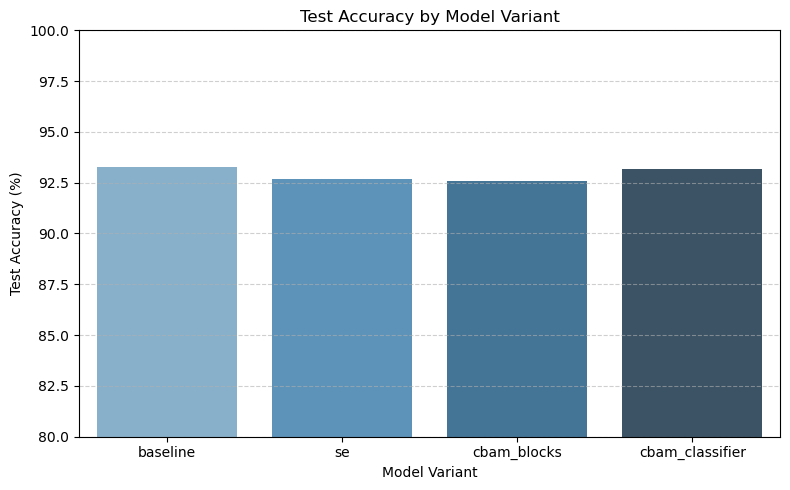

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Model", y="Test Acc (%)", palette="Blues_d")
plt.title("Test Accuracy by Model Variant")
plt.ylabel("Test Accuracy (%)")
plt.xlabel("Model Variant")
plt.ylim(80, 100)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\parth\AppData\Local\Temp\ipykernel_90152\2715510610.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="Model", y="Infer Time (ms/img)", palette="Oranges_d")


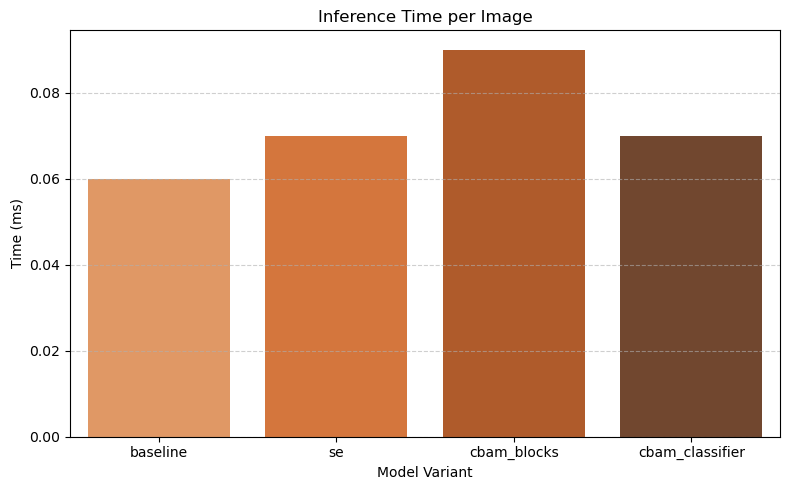

In [15]:
plt.figure(figsize=(8, 5))
sns.barplot(data=results_df, x="Model", y="Infer Time (ms/img)", palette="Oranges_d")
plt.title("Inference Time per Image")
plt.ylabel("Time (ms)")
plt.xlabel("Model Variant")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


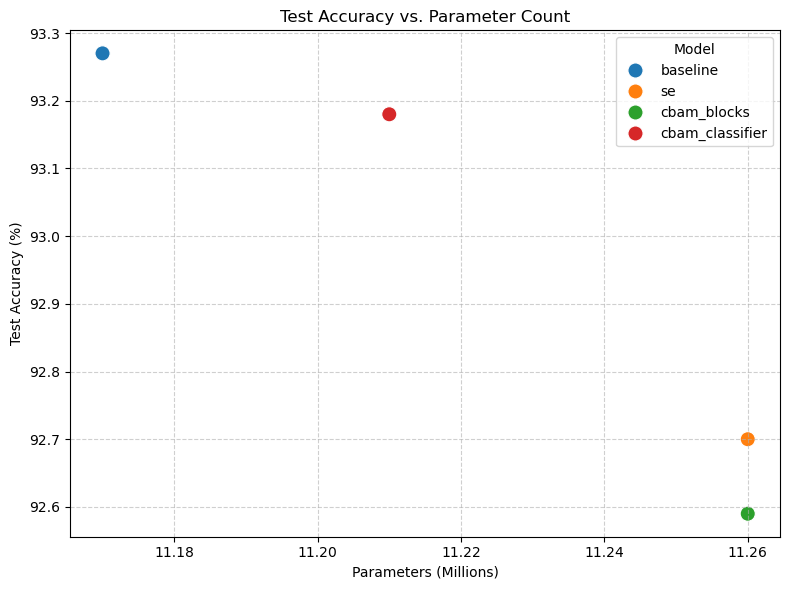

In [16]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df,
                x="Params (M)", y="Test Acc (%)",
                hue="Model", s=120)
plt.title("Test Accuracy vs. Parameter Count")
plt.xlabel("Parameters (Millions)")
plt.ylabel("Test Accuracy (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [4]:
import matplotlib.pyplot as plt
import torchvision
import torch

# Fashion MNIST class labels
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def show_predictions(model, dataloader, device, num_images=8):
    model.eval()
    model.to(device)

    images_shown = 0
    fig, axs = plt.subplots(1, num_images, figsize=(16, 4))
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                img = images[i].cpu().squeeze()
                true_label = classes[labels[i].item()]
                pred_label = classes[preds[i].item()]

                axs[images_shown].imshow(img, cmap='gray')
                axs[images_shown].set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=9)
                axs[images_shown].axis('off')
                images_shown += 1

            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()
